In [130]:
import script_utils as utils

# MODEL = "skill-agent-2-no-learning"
MODEL = "skill-claude-haiku-4.5"
DATASET = "train" # "test"

tasks = utils.get_tasks(MODEL, remove_corrupted=True, dataset=DATASET)

2026-02-22 04:21:24.086 | WARNING  | script_utils:get_tasks:94 - Warning: Only 156 tasks found, but 350 expected from ground truth.


In [28]:
times_domain_read = 0
times_skills_read = 0
for task in tasks:
    read_skills = False
    read_domain = False
    for i, traj in enumerate(task["trajectories"]):
        if "Tool Call: `read_skills`" in traj["response"]:
            read_skills = True
        if "Tool Call: `get_domain_skills`" in traj["response"]:
            read_domain = True
    if read_skills:
        times_skills_read += 1
    if read_domain:
        times_domain_read += 1

print(f"Times domain read: {times_domain_read}/{len(tasks)} -- {times_domain_read/len(tasks)*100:.2f}%")
print(f"Times skills read: {times_skills_read}/{len(tasks)} -- {times_skills_read/len(tasks)*100:.2f}%")
            
    

Times domain read: 0/166 -- 0.00%
Times skills read: 0/166 -- 0.00%


In [24]:
count = 0
for task in tasks:
    if "error_reasons" in task and len(task["error_reasons"]) > 0:
        print(task["error_reasons"])
        break
print(count/len(tasks))

['Task Incompleteness']
0.0


Total success rate: 71.79% (112/156)


,success_rate_%
domain,
gimp,90.909091
libreoffice_calc,90.476190
thunderbird,85.714286
chrome,77.272727
os,72.727273
libreoffice_impress,71.428571
vs_code,63.636364
libreoffice_writer,63.636364
vlc,57.142857


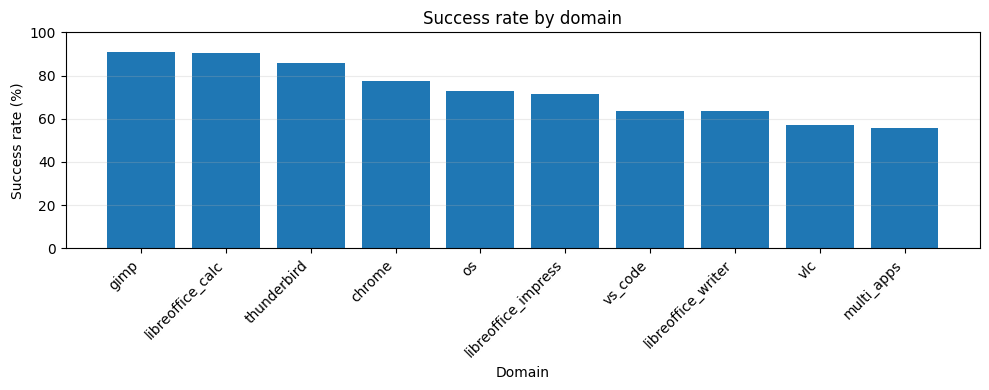

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(tasks).copy()
if df.empty:
    raise ValueError("No tasks found — run Cell 3 first.")

if "domain" not in df.columns or "success" not in df.columns:
    raise ValueError(f"Expected columns ['domain', 'success'] but got: {list(df.columns)}")

df["success_bool"] = df["success"].astype(bool)

# Total success rate (%)
total_success_rate = df["success_bool"].mean() * 100
print(f"Total success rate: {total_success_rate:.2f}% ({df['success_bool'].sum()}/{len(df)})")

# Success rate (%) by domain
success_rate = (
    df.groupby("domain")["success_bool"]
      .mean()
      .mul(100)
      .sort_values(ascending=False)
)

display(success_rate.rename("success_rate_%").to_frame())

plt.figure(figsize=(10, 4))
plt.bar(success_rate.index.astype(str), success_rate.values)
plt.ylabel("Success rate (%)")
plt.xlabel("Domain")
plt.ylim(0, 100)
plt.title("Success rate by domain")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", alpha=0.25)
plt.tight_layout()
plt.show()


In [132]:
# Define category bundles
category_mapping = {
    'os': 'OS',
    'libreoffice_calc': 'Office',
    'libreoffice_writer': 'Office',
    'libreoffice_impress': 'Office',
    'chrome': 'Daily',
    'vlc': 'Daily',
    'thunderbird': 'Daily',
    'vs_code': 'Professional',
    'gimp': 'Professional',
    'multi_apps': 'Workflow',
}

# Map domains to categories
df['category'] = df['domain'].str.lower().map(category_mapping)

# Calculate stats by category
category_stats = df.groupby('category').agg(
    total_tasks=('success_bool', 'count'),
    successful_tasks=('success_bool', 'sum'),
    success_rate=('success_bool', 'mean')
).reset_index()

category_stats['success_rate'] = (category_stats['success_rate'] * 100).round(2)
category_stats = category_stats.sort_values('success_rate', ascending=False)

# Add totals row
totals = pd.DataFrame({
    'category': ['TOTAL'],
    'total_tasks': [df['success_bool'].count()],
    'successful_tasks': [df['success_bool'].sum()],
    'success_rate': [round(df['success_bool'].mean() * 100, 2)]
})
category_stats = pd.concat([category_stats, totals], ignore_index=True)

# Display the table
category_stats.columns = ['Category', 'Total Tasks', 'Successful', 'Success Rate (%)']
display(category_stats)

,Category,Total Tasks,Successful,Success Rate (%)
0,Office,53,41,77.36
1,Professional,22,17,77.27
2,Daily,36,27,75.00
3,OS,11,8,72.73
4,Workflow,34,19,55.88
5,TOTAL,156,112,71.79


In [91]:
all_error_reasons = []

_error_map = {
    "UI Understanding": ["UI Grounding - Comprehension"],
    "UI Comprehension": ["UI Grounding - Comprehension"],
    "Website Navigation": ["Reasoning", "UI Grounding - Comprehension"],
    "Reasoning (Wrong Action)": ["Reasoning - Wrong Conclusion/Action"],
    "Planning Error": ["Reasoning - Wrong Conclusion/Action"],
    "Invalid": ["Infeasible"],
    "Task Ambiguity / Misunderstanding": ["Reasoning - Task Interpretation"],
    "Looping / Repetition": ["Reasoning - Looping"],
    "Task Incompleteness": ["Reasoning - Wrong Conclusion/Action"],
    "Hallucinated Action": ["UI Grounding - Hallucinated Action"],
    "Localization": ["UI Grounding - Localization"],
    "Unparseable Action": ["Reasoning - Unparseable Action"],
    "Infeasible": ["Others - Infeasible"],
    "Limit Reached": ["Others - Limit Reached"],
    "Insufficient Exploration": ["Reasoning - Wrong Conclusion/Action"],
    "UI Change / Element Not Found": ["UI Grounding - Comprehension"],
}

for task in tasks:
    error_reasons = task.get("error_reasons", [])
    if len(task.get("trajectories", [])) >= 50:
        all_error_reasons.append(["Limit Reached"])

    task_errors = set()
    

    for error_reason in error_reasons:
        errors = _error_map.get(error_reason, [error_reason])
        task_errors.update(errors)

    # Task-level deduplicater

        
    all_error_reasons.append(list(task_errors))

error_map = {}
for reasons in all_error_reasons:
    for reason in reasons:
        if reason not in error_map:
            error_map[reason] = 0
        error_map[reason] += 1
error_map

{'Reasoning - Wrong Conclusion/Action': 80,
 'UI Grounding - Comprehension': 69,
 'UI Grounding - Hallucinated Action': 20,
 'Limit Reached': 52,
 'Knowledge': 42,
 'Reasoning - Looping': 11,
 'UI Grounding - Localization': 37,
 'Reasoning - Task Interpretation': 2,
 'Reasoning - Unparseable Action': 3,
 'Others - Infeasible': 6}

In [92]:
errors = {
    "Planning": 0,
    "UI Grounding": 0,
    "Others": 0,
    
    "Reasoning": 0,

    "Knowledge": 0,
    "Reasoning - Wrong Conclusion/Action": 0,
    "Reasoning - Looping": 0,
    "Reasoning - Unparseable Action": 0,
    "Reasoning - Task Interpretation": 0,
    "UI Grounding - Comprehension": 0,
    "UI Grounding - Localization": 0,
    "UI Grounding - Hallucinated Action": 0,
    "Others - Limit Reached": 0,
    "Others - Infeasible": 0,
}

for task in tasks: 
    task_error_reasons = task.get("error_reasons", [])
    if len(task.get("trajectories", [])) >= 50:
        task_error_reasons.append("Limit Reached")

    error_reasons = set()
    for original_error_reason in task_error_reasons: 
        mapped_error_reasons = _error_map.get(original_error_reason, [original_error_reason])
        error_reasons.update(mapped_error_reasons)
    
    for error_reason in error_reasons:
        errors[error_reason] += 1

    contains_reasoning_error = any(error_reason.startswith("Reasoning - ") for error_reason in error_reasons)
    
    if contains_reasoning_error:
        errors["Reasoning"] += 1
    
    if any(error_reason.startswith("UI Grounding - ") for error_reason in error_reasons):
        errors["UI Grounding"] += 1
    
    if any(error_reason.startswith("Others - ") for error_reason in error_reasons):
        errors["Others"] += 1
    
    if any("Knowledge" == error_reason for error_reason in error_reasons) or contains_reasoning_error:
        errors["Planning"] += 1
    
errors     

{'Planning': 110,
 'UI Grounding': 95,
 'Others': 56,
 'Reasoning': 91,
 'Knowledge': 42,
 'Reasoning - Wrong Conclusion/Action': 80,
 'Reasoning - Looping': 11,
 'Reasoning - Unparseable Action': 3,
 'Reasoning - Task Interpretation': 2,
 'UI Grounding - Comprehension': 69,
 'UI Grounding - Localization': 37,
 'UI Grounding - Hallucinated Action': 20,
 'Others - Limit Reached': 52,
 'Others - Infeasible': 6}

In [115]:
import os
import json


RESULTS_DIR = r"D:\Projects\OSWorld-MA\results\pyautogui\screenshot\skill-claude-haiku-4.5"

for i, task in enumerate(tasks):
    domain = task["domain"]
    id = task["task_id"]

    task_dir = os.path.join(RESULTS_DIR, domain, id)
    if not os.path.exists(task_dir):
        print(f"Task dir not found: {task_dir}")
        continue

    with open(os.path.join(task_dir, "result.txt"), "r") as f:
        txt_result_score = float(f.read().strip())
    
    with open(os.path.join(task_dir, "summary", "results.json"), "r") as f:
        result_json = json.load(f)
        result_json = result_json[0]
        json_result_score = result_json["score"]
    

    if txt_result_score != json_result_score:
        print(f"{i+1}: Score mismatch for task {domain}/{id}: txt={txt_result_score} vs json={json_result_score}")


5: Score mismatch for task chrome/121ba48f-9e17-48ce-9bc6-a4fb17a7ebba: txt=0.0 vs json=1.0
13: Score mismatch for task chrome/3720f614-37fd-4d04-8a6b-76f54f8c222d: txt=0.0 vs json=1.0
15: Score mismatch for task chrome/480bcfea-d68f-4aaa-a0a9-2589ef319381: txt=0.0 vs json=1.0
21: Score mismatch for task chrome/7f52cab9-535c-4835-ac8c-391ee64dc930: txt=0.0 vs json=1.0
24: Score mismatch for task chrome/93eabf48-6a27-4cb6-b963-7d5fe1e0d3a9: txt=0.0 vs json=1.0
27: Score mismatch for task chrome/9f3f70fc-5afc-4958-a7b7-3bb4fcb01805: txt=0.0 vs json=1.0
30: Score mismatch for task chrome/a96b564e-dbe9-42c3-9ccf-b4498073438a: txt=0.0 vs json=1.0
37: Score mismatch for task chrome/cabb3bae-cccb-41bd-9f5d-0f3a9fecd825: txt=0.0 vs json=1.0
45: Score mismatch for task gimp/045bf3ff-9077-4b86-b483-a1040a949cff: txt=0.0 vs json=1.0
46: Score mismatch for task gimp/06ca5602-62ca-47f6-ad4f-da151cde54cc: txt=0.0 vs json=1.0
48: Score mismatch for task gimp/2e6f678f-472d-4c55-99cc-8e7c5c402a71: txt=

In [41]:
input_tokens, cached_input_tokens, output_tokens = 0, 0, 0
for task in tasks:
    trajs = task.get("trajectories", [])
    for traj in trajs:
        usage = traj["usage"]
        input_tokens += usage["input_tokens"]
        cached_input_tokens += usage.get("cached_input_tokens", 0)
        output_tokens += usage["output_tokens"]

In [ ]:
input_tokens, cached_input_tokens, output_tokens = 0, 0, 0
for task in tasks:
    input_tokens += task["usage_input_tokens"]
    cached_input_tokens += task["usage_cached_input_tokens"]
    output_tokens += task["usage_output_tokens"]

In [42]:
print(f"Input tokens: {input_tokens}")
print(f"Cached input tokens: {cached_input_tokens}")
print(f"Output tokens: {output_tokens}")

Input tokens: 12144039
Cached input tokens: 5378432
Output tokens: 701092


In [30]:
steps = sum(task["steps"] for task in tasks)
print(f"Total steps: {steps}")

Total steps: 1281


In [31]:
avg_steps = steps / len(tasks) if tasks else 0
print(f"Average steps per task: {avg_steps:.2f}")

Average steps per task: 14.56


In [96]:
time = steps * 15  # assuming each step takes 10 seconds
time += output_tokens / 77  # assuming each token takes 1/77 seconds
time

159707.2987012987

In [97]:
steps * 15

132360

In [23]:
time_per_task = time / len(tasks) if tasks else 0
time_per_task

NameError: name 'time' is not defined

In [ ]:
t = None
for task in tasks:
    if task["domain"] == "gimp":
        if task["task_id"] == "2a729ded-3296-423d-aec4-7dd55ed5fbb3":
            t = task

In [55]:
for traj in t["trajectories"]:
    usage = traj["usage"]
    print(usage)

{'input_tokens': 5869, 'output_tokens': 438, 'cached_input_tokens': 1408}
{'input_tokens': 7762, 'output_tokens': 921, 'cached_input_tokens': 1408}
{'input_tokens': 8098, 'output_tokens': 298, 'cached_input_tokens': 3072}
{'input_tokens': 5258, 'output_tokens': 508, 'cached_input_tokens': 7808}
{'input_tokens': 11889, 'output_tokens': 129, 'cached_input_tokens': 3072}
{'input_tokens': 9709, 'output_tokens': 362, 'cached_input_tokens': 3072}
{'input_tokens': 12022, 'output_tokens': 130, 'cached_input_tokens': 3072}
{'input_tokens': 13765, 'output_tokens': 316, 'cached_input_tokens': 1408}
{'input_tokens': 12053, 'output_tokens': 461, 'cached_input_tokens': 3200}
{'input_tokens': 12265, 'output_tokens': 835, 'cached_input_tokens': 3072}
{'input_tokens': 9711, 'output_tokens': 460, 'cached_input_tokens': 3456}
{'input_tokens': 12153, 'output_tokens': 820, 'cached_input_tokens': 3328}
{'input_tokens': 12109, 'output_tokens': 862, 'cached_input_tokens': 3456}
{'input_tokens': 11940, 'output